<a href="https://colab.research.google.com/github/jeremiahVaris/deep-learning-practice/blob/master/style_transfer_using_CNNs/VGGNet/Image_Style_Transfer_Using_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Style Transfer Using Convolutional Neural Networks

This notebook attempts to replicate the results of the style transfer algorithm outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) using Pytorch. The paper proposes a method to blend the artistic style of one image with the object content of another, thus effectively transfering the style of one image onto another image. 


## VGGNet
The algorithm proposed in this paper makes use of the 19-Layer VGG Convolutional Neural Network architecture. In this notebook, I make use of Pytorch's VGG19 model which has been pretrained on the ImageNet dataset. The network consists of a series of convolutional and pooling layers, with some fully-connected layers at the end for classification. As shown in the image below, the first convolutional layer that the image is passed through, in the first stack is named conv1_1. The first convolutional layer in the second stack is conv2_1, and so on, with the deepest layer being conv5_4 (the fourth layer in the fifth stack).

![Image of VGG19 architecture](https://github.com/Udacity/deep-learning-v2-pytorch/raw/master/style-transfer/notebook_ims/vgg19_convlayers.png)



## Style Transfer
Style Transfer, as proposed here, relies on the ability of the network to generate separate representations for the object content, and the style content (style, colours and textures) of an image. The aim is to take the content representation of a **content image** and blend with the style representation of a **style image** to create a new target image with the content of the content image expressed in the style of the style image, thus effectively transfering the style of one image onto another.

An example is shown below, where the content image is of a skyline, and the style image is [Sonia Delaunay's *Electric Prisms* (1914)](https://www.theartstory.org/artist-delaunay-sonia-artworks.htm). The result is a target image with the content of the skyline image recreated in a semblance of the style of *Electric Prisms*.

![Image showing style transfer](https://github.com/jeremiahVaris/deep-learning-practice/raw/master/style_transfer_using_CNNs/VGGNet/images/Style%20transfer.png)



In [0]:
# Load in modules
%matplotlib inline

# Pytorch modules
import torch
import torch.optim as optim
from torchvision import transforms, models 

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

## Load in VGG19 features
The VGG19 is divided into two parts:


*   `vgg19.features`, which consists of the pooling and convolutional layers
*   `vgg19.classifier`, which contains the fully connected layers.

Since this is not a classification problem, only the features are needed for the style and content representations. Also since the network is pretrained and there is no further training involved, the features parameters will be 'frozen', so as not to change during backpropagation.



In [2]:
# Load in VGG-19 features
vgg = models.vgg19(pretrained=True).features

# Freeze the features parameters since we're not doing any training on the model
for parameter in vgg.parameters():
  parameter.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:22<00:00, 25168517.86it/s]


In [3]:
# Move the model to GPU for training (if available)
if torch.cuda.is_available():
  device = "cuda"
  print ("Training on GPU")
else:
  device = "cpu"
  print ("Training on CPU!")
  
vgg.to(device) # Show VGG19 layers




Training on GPU


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## Load in content and style images
In the function below, the images are loaded in and a couple of preprocessing transforms performed on them to prepare them for entry into the VGGNet. 

Large image sizes require longer time for the network to process, thus the images are resized, where necessary, to make them smaller. Also, the content and style image are adjusted to be of the same size to make processing easier.

In [0]:
# Load in images
def load_image(image_path, max_size=400, shape=None):
  '''Load in image and resize (where necessary) to ensure
  that image size is not too high. Also perform other transforms
  to prepare the image for the CNN'''
  
  image = Image.open(image_path).convert('RGB')
  
  if max(image.size) > max_size:
    size = max_size
  else:
    size = min(image.size)
    
  if shape is not None:
        size = shape
  
  transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]) # Standard values for Pytorch pretrained models
  ])
  
  # Discard fourth (alpha) channel if present and add batch dimension
  image = transform(image)[:3,:,:].unsqueeze(0)
  
  return image
  

Here, I load the content and style images from my Google drive and force the style image to be of the same shape as the content image.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# load in content and style images
content = load_image('/content/gdrive/My Drive/deep-learning-v2-pytorch/style-transfer/images/space_needle.jpg').to(device)
# Resize style to match content, makes implementation easier
style = load_image('/content/gdrive/My Drive/deep-learning-v2-pytorch/style-transfer/images/delaunay.jpg', shape=content.shape[-2:]).to(device)



In [0]:
def convert_to_numpy(tensor):
  '''For display, unnormalize image and convert to numpy array'''
  
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)
    
  return image
  

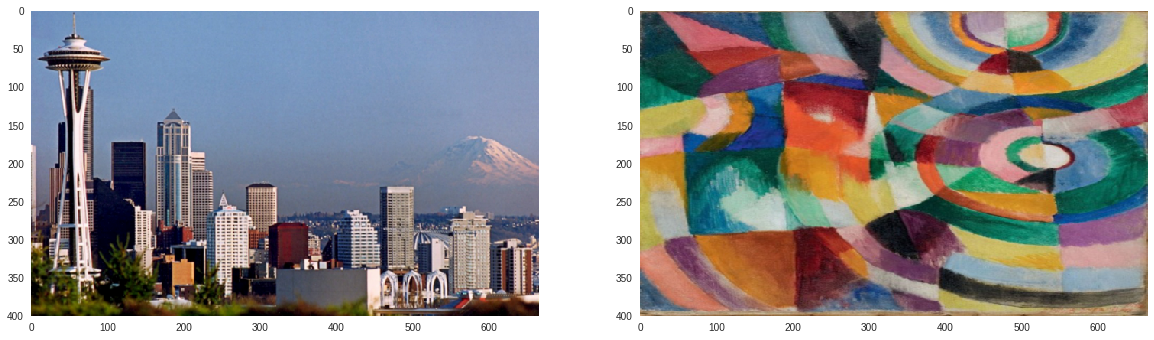

In [16]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style images side-by-side
ax1.grid(False)
ax1.imshow(convert_to_numpy(content))
ax2.grid(False)
ax2.imshow(convert_to_numpy(style))

## Content and style features
For CNNs trained on object identification, such as VGG19, the image representations developed by the layers are increasingly sensitive to the actual image content, the deeper the layer is in the CNN. 

In this paper, the features used to represent the content information are those gotten from the `conv4_2` layer. This layer is deep enough in the network to sufficiently give the content representation..


To obtain the style representation, the paper proposes the use of a feature space that consists of correlations between different filter responses of multiple layers of the network. These feature correlations are given by the [Gram matrices](https://en.wikipedia.org/wiki/Gramian_matrix) for these multiple layers. This yeilds a multi-scale representation of the input image that captures it's style information but not the spatial arrangement of objects.

The feature layers selected for the style computations according to the paper are the `conv1_1`, `conv2_1`, `conv3_1`, `conv4_1`, and `conv5_1` layers.

In [0]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    # Map the layer names from the paper to the corresponding layer number for the 
    # VGGNet architecture, to get content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [0]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor (the outputs of the 
        convolutional layers) 
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

## Combination of Style and content
The style transfer is achieved by synthesizing a new image that matches the content representation of the content image and the style representation of the style image simultaneously. This matching is done by defining a loss function that is a linear combination of the style loss and content loss.

The content loss is defined as the mean squared error between the content representations of the content and new (target) images. The style loss is defined as a weighted sum of the mean squared errors between the style representations of the style image and the new image, for each of the layers of the network considered above.

The target image is initially created as a white noise image (or as a clone of either the content or style images). Gradient descent is then performed on this target image over successive iterations to reduce the style and content losses to a desirable extent. As the style and content losses reduce, the target image successively matches the style of the style image and has the content of the of the content image.

In [0]:
# get content and style features only once before training
content_features = get_features(content, vgg)
# print (content_features)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# Here, I start with a target image that is a clone of the content image, to produce a target image that is more biased towards the content image
target = content.clone().requires_grad_(True).to(device)

## Loss and weights
### Style layer weights
The style loss is a weighted sum of the individual style losses of the different layers considered. We can alter the weights to give precedence to shallower or deeper layers and observe a difference in how much the output image is *stylized*.

### Content and Style Weight
The total loss is a linear combination of the content loss and the style loss. These losses are combined using a ratio that determines the amount of trade-off between content features and style features in the final output.

In [0]:
# Define the weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

# Define the ratio by which the style and content losses are combined
content_weight = 1  # alpha
style_weight = 1e6  # beta

## Updating the target image using gradient descent
The code below presents an iteration loop for matching the style and content features of the target image to those of the style and content images respectively.

A demonstration is run below, after which, in subsequent code blocks, different parameters are adjusted to see the effect on the nature of the output.

In [0]:
def transfer_style(steps = 5000, # Number of iterations to update target image 
                   show_every=None  # for displaying the target image, intermittently
                  ):

  # iteration hyperparameters
  optimizer = optim.Adam([target], lr=0.003)
  

  for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if show_every is not None:
        if ii % show_every == 0:
#           print('Content loss: ', content_loss.item())
#           print('Style loss: ', style_loss.item())
          print('Total loss: ', total_loss.item())
          plt.imshow(convert_to_numpy(target))
          plt.show()
          
   


In [0]:
 transfer_style()

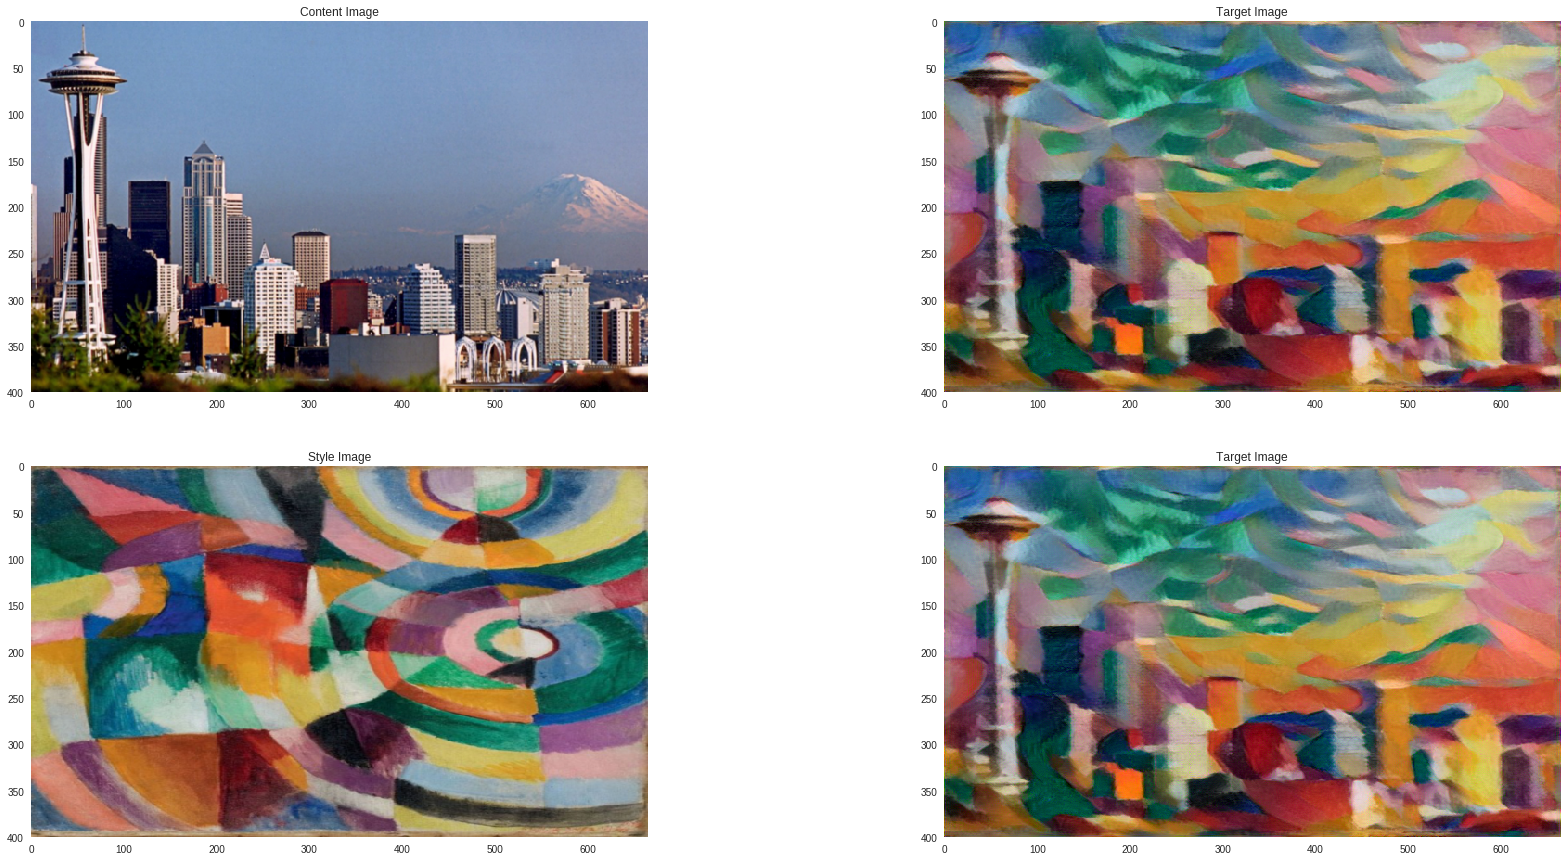

In [20]:
# display content, style and final, target image
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(30, 15))
ax1.grid(False)
ax1.set_title('Content Image')
ax1.imshow(convert_to_numpy(content))

ax2.grid(False)
ax2.set_title('Target Image')
ax2.imshow(convert_to_numpy(target))

ax3.grid(False)
ax3.set_title('Style Image')
ax3.imshow(convert_to_numpy(style))

ax4.grid(False)
ax4.set_title('Target Image')
ax4.imshow(convert_to_numpy(target))


# Results
As demonstrated above, the algorithm effectively transfered the artistic style of the *Delaunay* onto the picture of the skyline using the parameters that have been specified above. 
